In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report, 
                           accuracy_score, balanced_accuracy_score, 
                           precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_selected_features(X, feature_names, selected_vars):
    """Helper function to get indices of selected features"""
    selected_indices = [i for i, name in enumerate(feature_names) 
                       if name in selected_vars]
    return X[:, selected_indices]

def create_feature_names(n_features):
    feature_names = []
    for i in range(n_features):
        if i < 41:
            feature_names.append(f'XMEAS({i+1})')
        else:
            feature_names.append(f'XMV({i-40})')
    return feature_names

def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0)
    if 'Fault' in data.columns:
        data = data.drop('Fault', axis=1)
    return data.values

def create_separate_datasets():
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for i in range(21):
        train_file = os.path.join(data_path, f'd{i:02d}.csv')
        train_data = load_data(train_file)
        
        if i == 0:
            X_train.append(train_data)
            y_train.append(np.zeros(train_data.shape[0]))
        else:
            X_train.append(train_data)
            labels = np.zeros(train_data.shape[0])
            labels[20:] = 1
            y_train.append(labels)
    
    for i in range(21):
        test_file = os.path.join(data_path, f'd{i:02d}_te.csv')
        test_data = load_data(test_file)
        
        if i == 0:
            X_test.append(test_data)
            y_test.append(np.zeros(test_data.shape[0]))
        else:
            X_test.append(test_data)
            y_test.append(np.ones(test_data.shape[0]))
    
    return (np.vstack(X_train), np.concatenate(y_train), 
            np.vstack(X_test), np.concatenate(y_test))

In [5]:
def train_mlp_classifier(X_train, X_test, y_train, y_test, model_name=""):
    """
    Train MLPClassifier and return performance metrics
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_train_int = le.fit_transform(y_train)
    y_test_int = le.transform(y_test)
    
    sampling_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
    ])
    
    print(f"\nTraining {model_name} (features: {X_train.shape[1]})...")
    X_train_resampled, y_train_resampled = sampling_pipeline.fit_resample(X_train_scaled, y_train_int)
    
    param_distributions = {
        'hidden_layer_sizes': [(300,150,75), (250,125,60), (200,150,100,50)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.005, 0.001, 0.0005],
        'alpha': [0.0001, 0.001],
        'batch_size': [64, 128]
    }
    
    base_mlp = MLPClassifier(
        solver='adam',
        learning_rate='adaptive',
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=42
    )
    
    random_search = RandomizedSearchCV(
        base_mlp,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train_resampled, y_train_resampled)
    best_model = random_search.best_estimator_
    
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Model': model_name,
        'N_Features': X_train.shape[1],
        'Accuracy': accuracy_score(y_test_int, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test_int, y_pred),
        'Precision': precision_score(y_test_int, y_pred),
        'Recall': recall_score(y_test_int, y_pred),
        'AUC Score': roc_auc_score(y_test_int, y_pred_proba)
    }
    
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return metrics

In [7]:
def train_knn_classifier(X_train, X_test, y_train, y_test, model_name=""):
    """
    Train KNN Classifier and return performance metrics
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_train_int = le.fit_transform(y_train)
    y_test_int = le.transform(y_test)
    
    sampling_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
    ])
    
    print(f"\nTraining {model_name} (features: {X_train.shape[1]})...")
    X_train_resampled, y_train_resampled = sampling_pipeline.fit_resample(X_train_scaled, y_train_int)
    
    param_distributions = {
        'n_neighbors': [3, 5, 7, 9, 11, 13],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2],  
        'leaf_size': [20, 30, 40]
    }
    
    base_knn = KNeighborsClassifier(
        n_jobs=-1  
    )
    
    random_search = RandomizedSearchCV(
        base_knn,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train_resampled, y_train_resampled)
    best_model = random_search.best_estimator_
    
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Model': model_name,
        'N_Features': X_train.shape[1],
        'Accuracy': accuracy_score(y_test_int, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test_int, y_pred),
        'Precision': precision_score(y_test_int, y_pred),
        'Recall': recall_score(y_test_int, y_pred),
        'AUC Score': roc_auc_score(y_test_int, y_pred_proba)
    }
    
    metrics.update({f'best_{k}': v for k, v in random_search.best_params_.items()})
    
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return metrics

In [9]:
def train_xgboost_classifier(X_train, X_test, y_train, y_test, model_name="", feature_names=None):
    """
    Train XGBoost Classifier and return performance metrics
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_train_int = le.fit_transform(y_train)
    y_test_int = le.transform(y_test)
    
    sampling_pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.8, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
    ])
    
    print(f"\nTraining {model_name} (features: {X_train.shape[1]})...")
    X_train_resampled, y_train_resampled = sampling_pipeline.fit_resample(X_train_scaled, y_train_int)
    
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2]
    }
    
    base_xgb = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_jobs=-1
    )
    
    random_search = RandomizedSearchCV(
        base_xgb,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    random_search.fit(X_train_resampled, y_train_resampled)
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Model': model_name,
        'N_Features': X_train.shape[1],
        'Accuracy': accuracy_score(y_test_int, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test_int, y_pred),
        'Precision': precision_score(y_test_int, y_pred),
        'Recall': recall_score(y_test_int, y_pred),
        'AUC Score': roc_auc_score(y_test_int, y_pred_proba)
    }
    
    metrics.update({f'best_{k}': v for k, v in random_search.best_params_.items()})
    
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    if X_train.shape[1] <= 20 and feature_names is not None:  
        if isinstance(feature_names, list):
            feature_names_subset = feature_names[:X_train.shape[1]]
        else:
            feature_names_subset = feature_names
            
        plt.figure(figsize=(10, 6))
        feature_importance = pd.DataFrame({
            'feature': feature_names_subset,
            'importance': best_model.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
    
    return metrics

Loading and preparing datasets...

Training full_dataset (features: 52)...


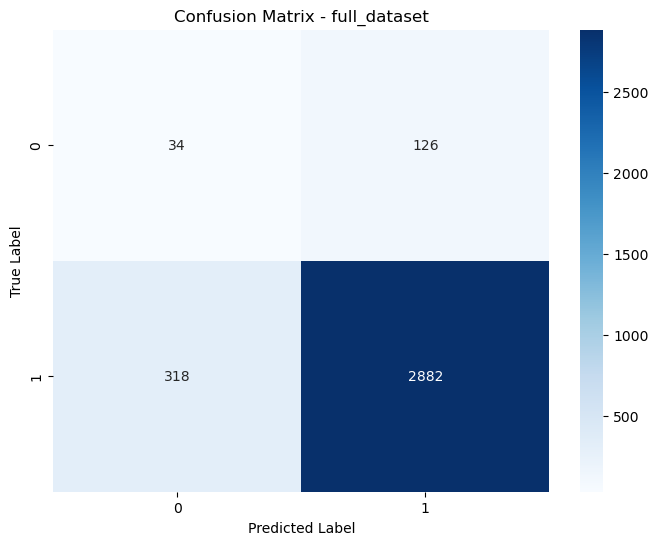


Training shap_7_vars) (features: 7)...


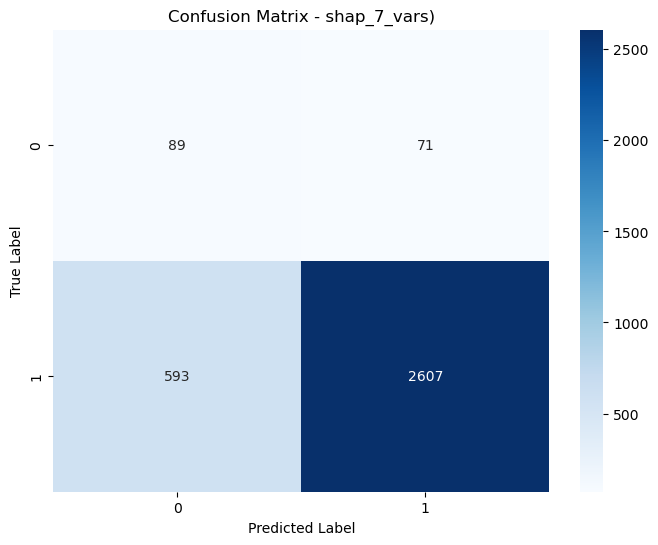


Training shap_10_vars) (features: 10)...


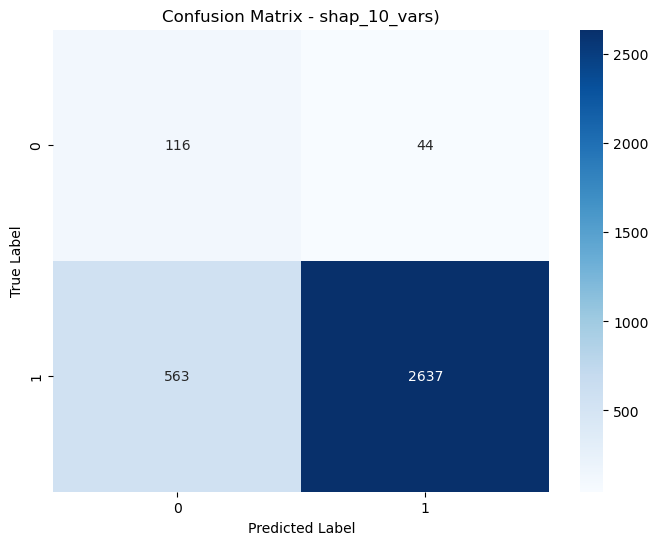


Training shap_12_vars) (features: 12)...


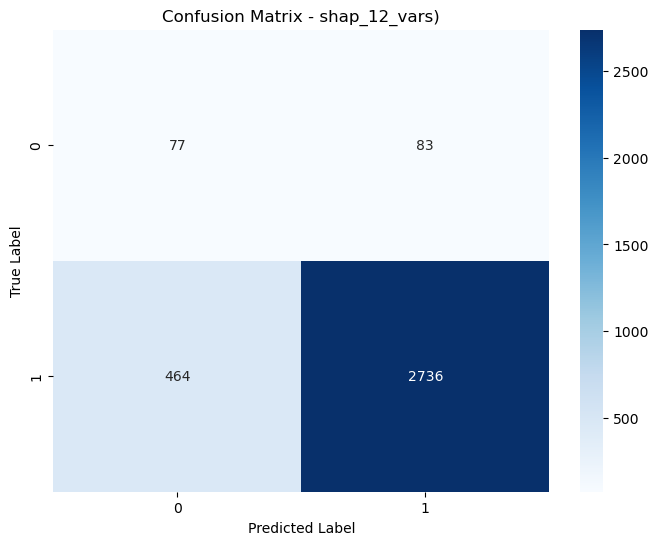


Training shap_15_vars) (features: 15)...


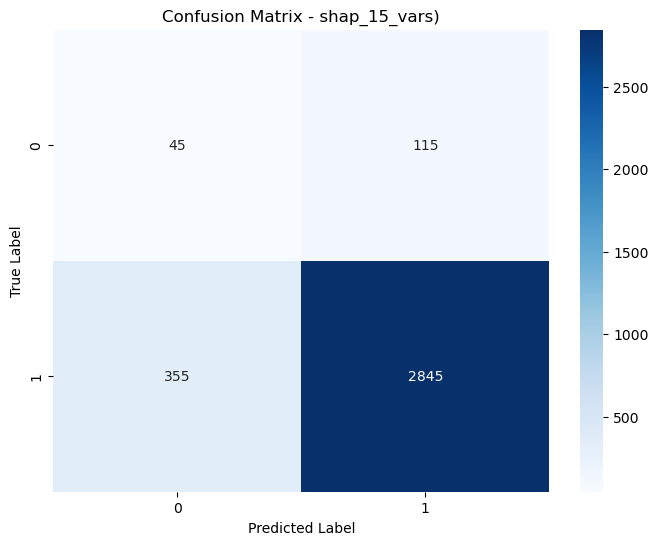


Training fpcmci_7_vars) (features: 7)...


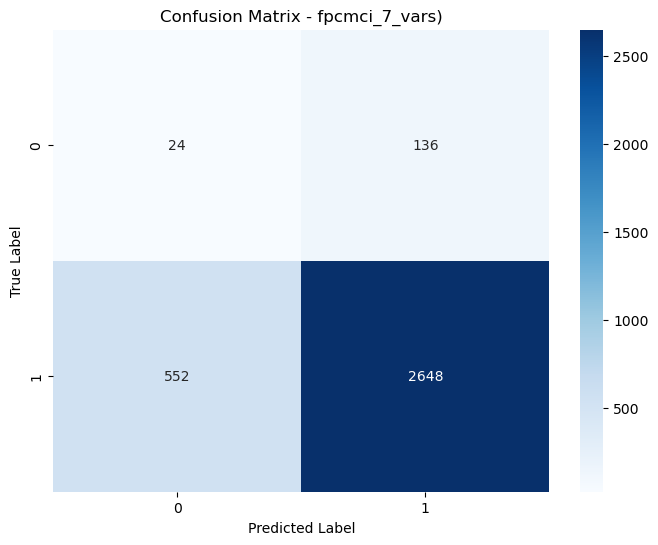


Training fpcmci_10_vars) (features: 10)...


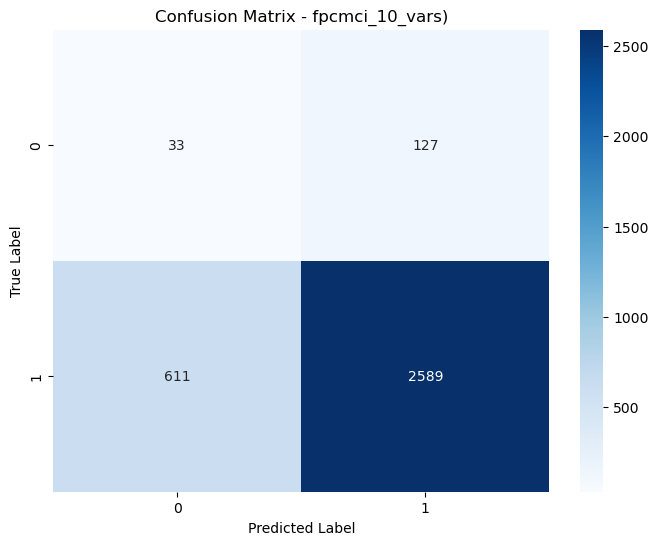


Training fpcmci_12_vars) (features: 12)...


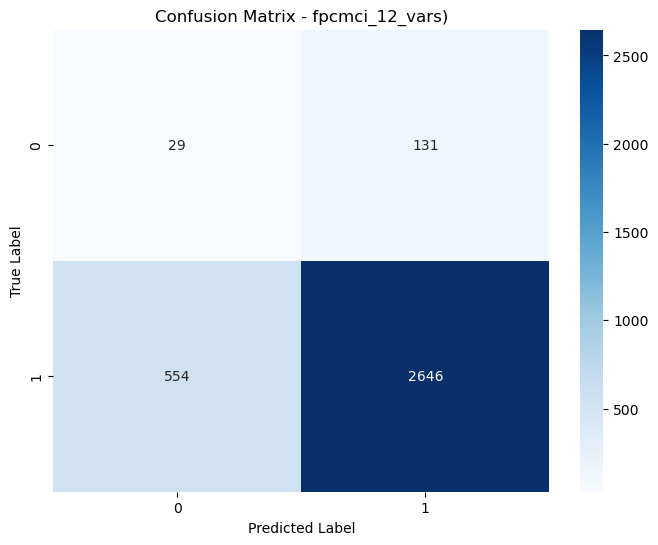


Training fpcmci_15_vars) (features: 15)...


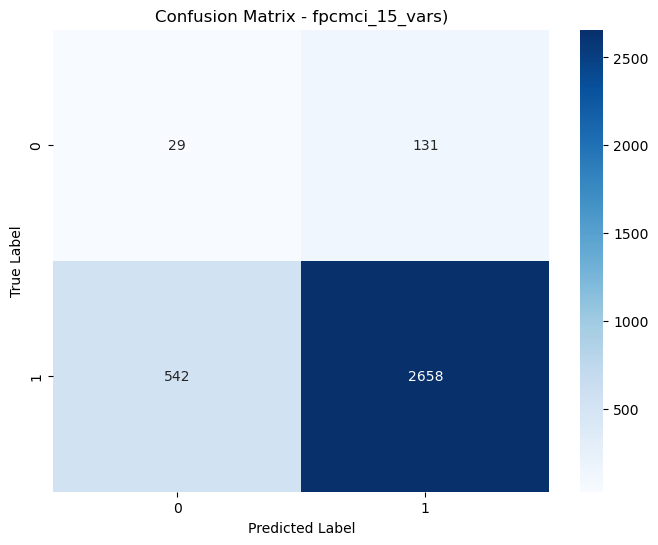


Model Comparison (sorted by Balanced Accuracy):
                 N_Features  Accuracy  Balanced Accuracy  Precision  Recall  \
Model                                                                         
shap_10_vars)            10    0.8193             0.7745     0.9836  0.8241   
shap_7_vars)              7    0.8024             0.6855     0.9735  0.8147   
shap_12_vars)            12    0.8372             0.6681     0.9706  0.8550   
shap_15_vars)            15    0.8601             0.5852     0.9611  0.8891   
full_dataset             52    0.8679             0.5566     0.9581  0.9006   
fpcmci_10_vars)          10    0.7804             0.5077     0.9532  0.8091   
fpcmci_15_vars)          15    0.7997             0.5059     0.9530  0.8306   
fpcmci_12_vars)          12    0.7961             0.5041     0.9528  0.8269   
fpcmci_7_vars)            7    0.7952             0.4888     0.9511  0.8275   

                 AUC Score  
Model                       
shap_10_vars)       0.8

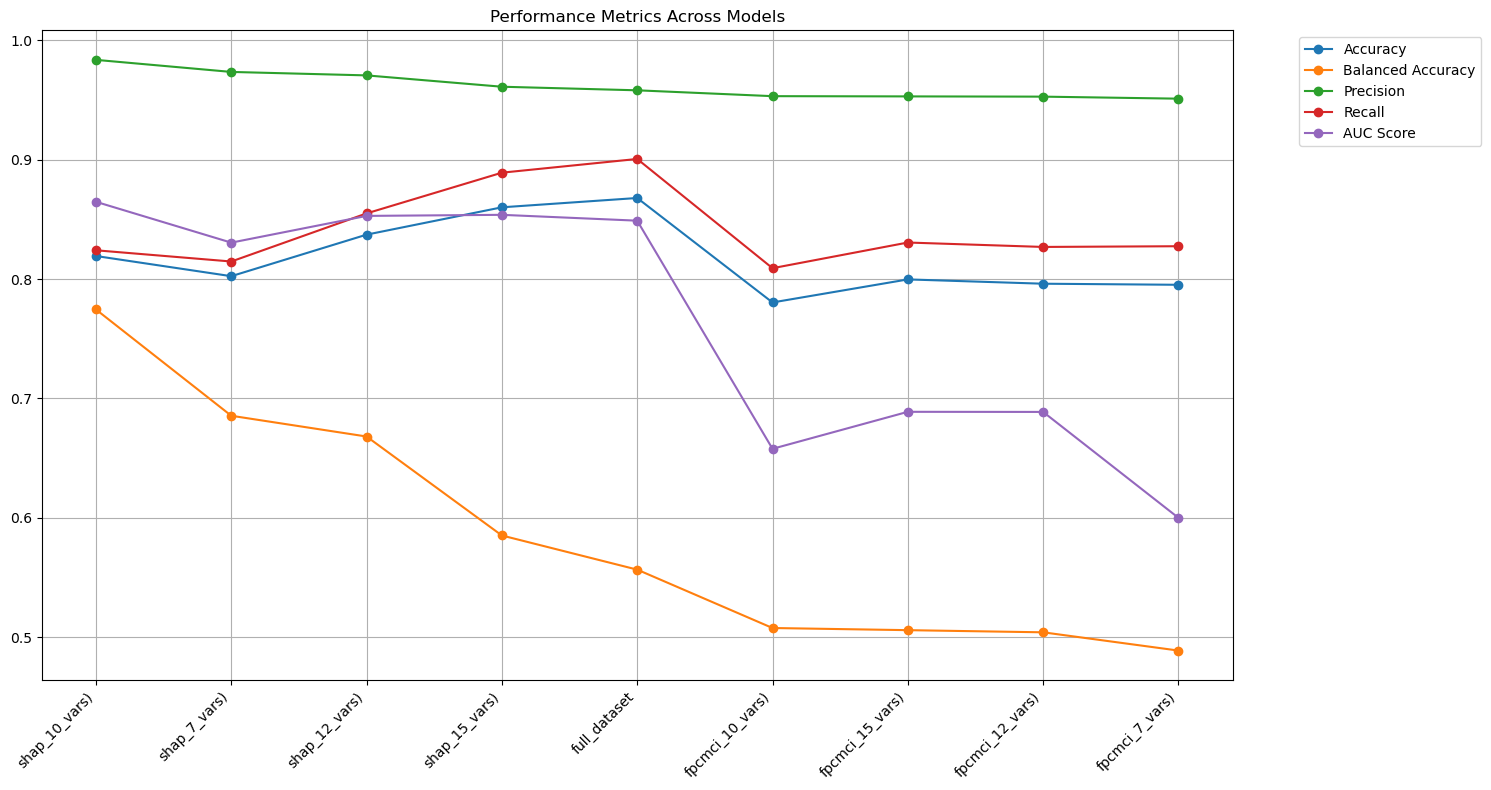

In [11]:
if __name__ == "__main__":
    data_path = 'Downloads/data_tep/'
    
    shap_vars = ["XMV(11)", "XMEAS(17)", "XMEAS(20)", "XMV(10)", 
                 "XMEAS(18)", "XMEAS(5)", "XMEAS(24)", "XMEAS(9)", 
                 "XMEAS(21)", "XMEAS(8)", "XMEAS(39)", "XMEAS(1)",
                 "XMEAS(37)", "XMEAS(6)", "XMEAS(14)"]
    
    fpcmci_vars = ["XMEAS(12)", "XMV(7)", "XMEAS(17)", "XMEAS(2)", 
                   "XMEAS(40)", "XMV(8)", "XMEAS(15)", "XMEAS(39)", 
                   "XMEAS(14)", "XMEAS(25)", "XMEAS(26)", "XMEAS(5)",
                   "XMV(1)", "XMEAS(41)", "XMEAS(28)"]
    
    n_vars_list = [7, 10, 12, 15]
    
    print("Loading and preparing datasets...")
    X_train, y_train, X_test, y_test = create_separate_datasets()
    feature_names = create_feature_names(X_train.shape[1])
    
    results = []
    
    metrics_full = train_mlp_classifier(X_train, X_test, y_train, y_test, "full_dataset")
    results.append(metrics_full)
    
    for n_vars in n_vars_list:
        selected_vars = shap_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics = train_mlp_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"shap_{n_vars}_vars)"
        )
        results.append(metrics)
    
    for n_vars in n_vars_list:
        selected_vars = fpcmci_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics = train_mlp_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"fpcmci_{n_vars}_vars)"
        )
        results.append(metrics)
    
    comparison_df = pd.DataFrame(results)
    comparison_df = comparison_df.set_index('Model')
    comparison_df = comparison_df.round(4)
    
    comparison_df = comparison_df.sort_values('Balanced Accuracy', ascending=False)
    
    print("\nModel Comparison (sorted by Balanced Accuracy):")
    print(comparison_df)
    
    comparison_df.to_csv('model_comparison_results_detailed.csv')
    print("\nResults have been saved to 'model_comparison_results_detailed.csv'")
    
    plt.figure(figsize=(15, 8))
    metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC Score']
    
    for metric in metrics_to_plot:
        plt.plot(comparison_df.index, comparison_df[metric], marker='o', label=metric)
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Performance Metrics Across Models')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Loading and preparing datasets...

Training full_dataset (features: 52)...


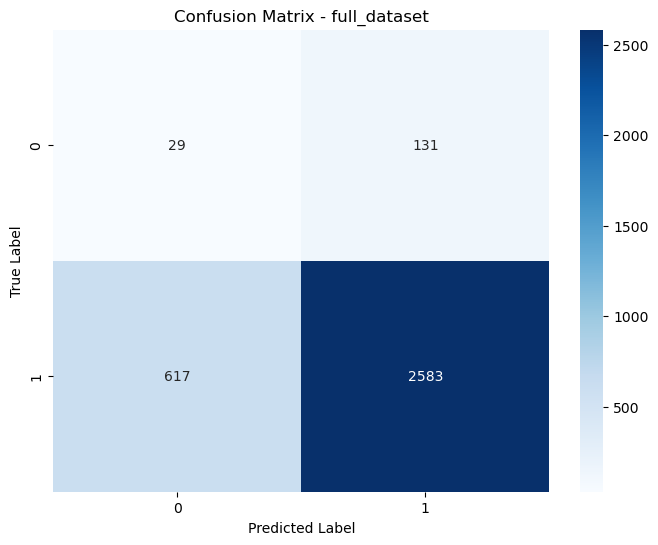


Training shap_7_vars) (features: 7)...


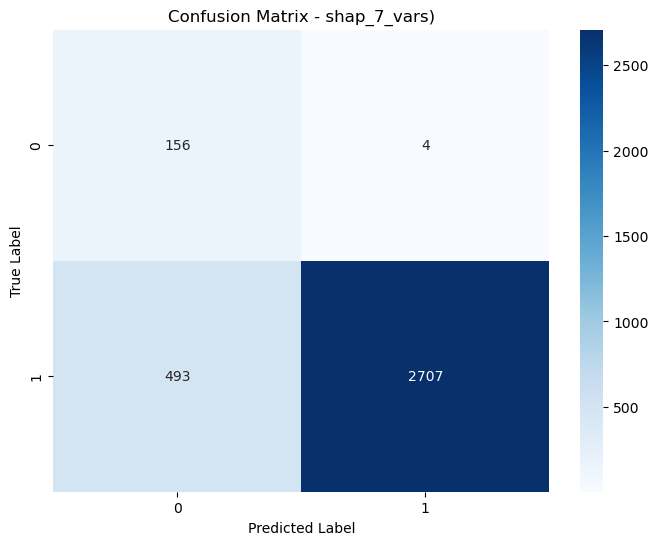


Training shap_10_vars) (features: 10)...


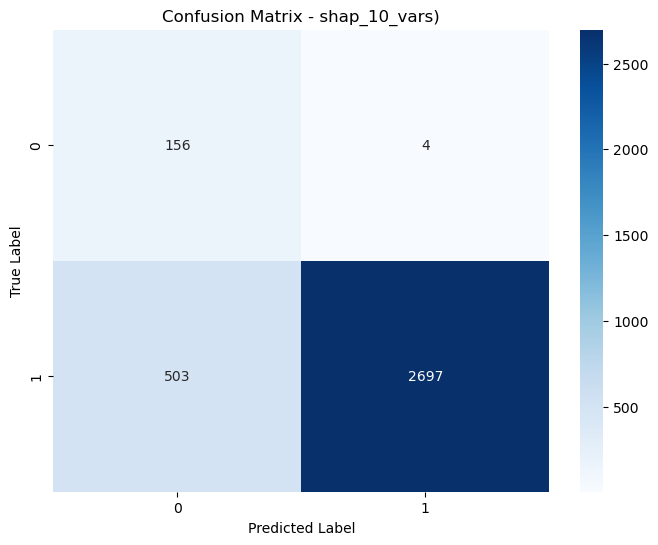


Training shap_12_vars) (features: 12)...


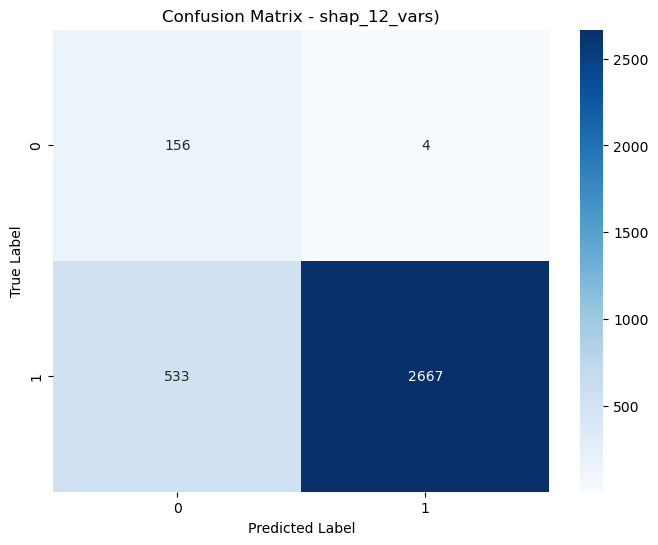


Training shap_15_vars) (features: 15)...


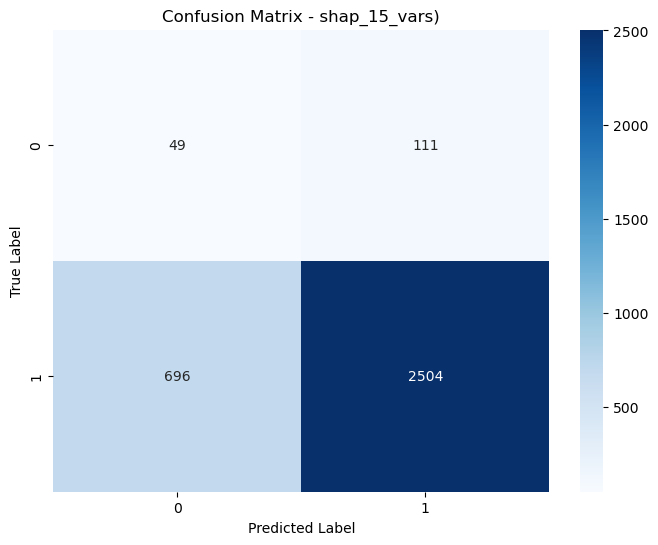


Training fpcmci_7_vars) (features: 7)...


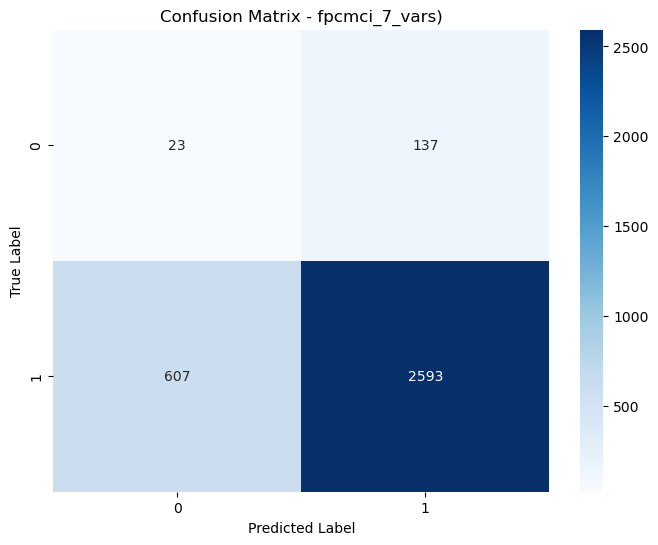


Training fpcmci_10_vars) (features: 10)...


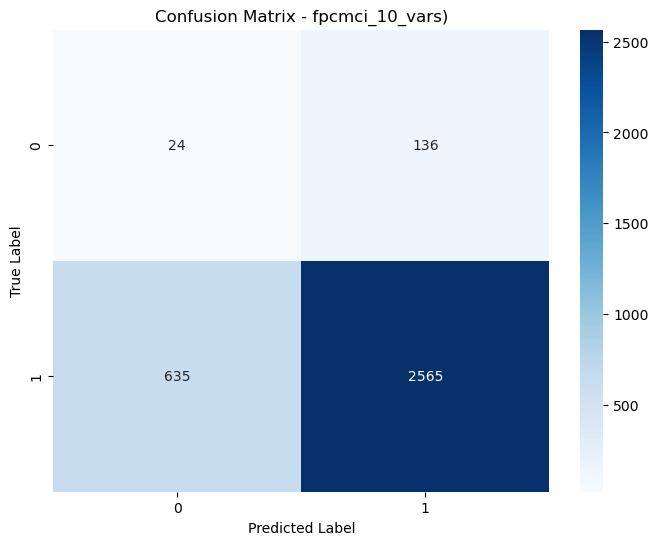


Training fpcmci_12_vars) (features: 12)...


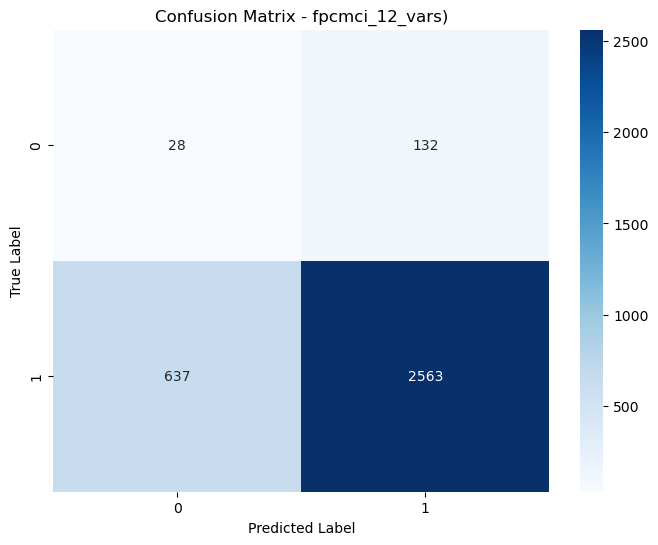


Training fpcmci_15_vars) (features: 15)...


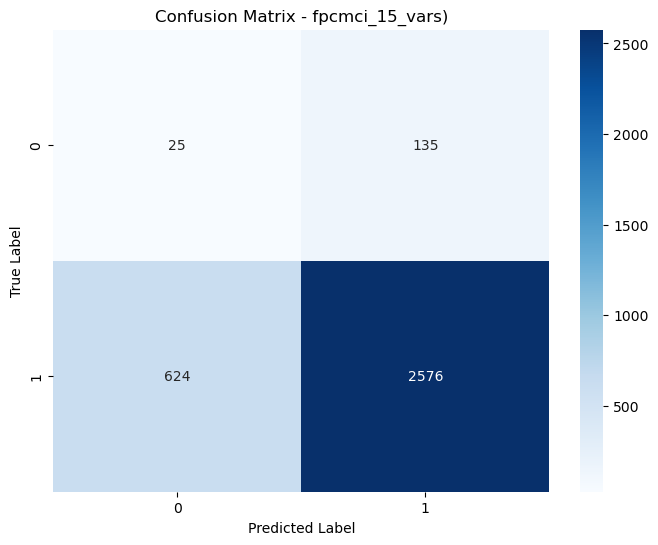


Model Comparison (sorted by Balanced Accuracy):
                 N_Features  Accuracy  Balanced Accuracy  Precision  Recall  \
Model                                                                         
shap_7_vars)              7    0.8521             0.9105     0.9985  0.8459   
shap_10_vars)            10    0.8491             0.9089     0.9985  0.8428   
shap_12_vars)            12    0.8402             0.9042     0.9985  0.8334   
shap_15_vars)            15    0.7598             0.5444     0.9576  0.7825   
full_dataset             52    0.7774             0.4942     0.9517  0.8072   
fpcmci_12_vars)          12    0.7711             0.4880     0.9510  0.8009   
fpcmci_15_vars)          15    0.7741             0.4806     0.9502  0.8050   
fpcmci_7_vars)            7    0.7786             0.4770     0.9498  0.8103   
fpcmci_10_vars)          10    0.7705             0.4758     0.9496  0.8016   

                 AUC Score best_weights  best_p  best_n_neighbors best_metric  \


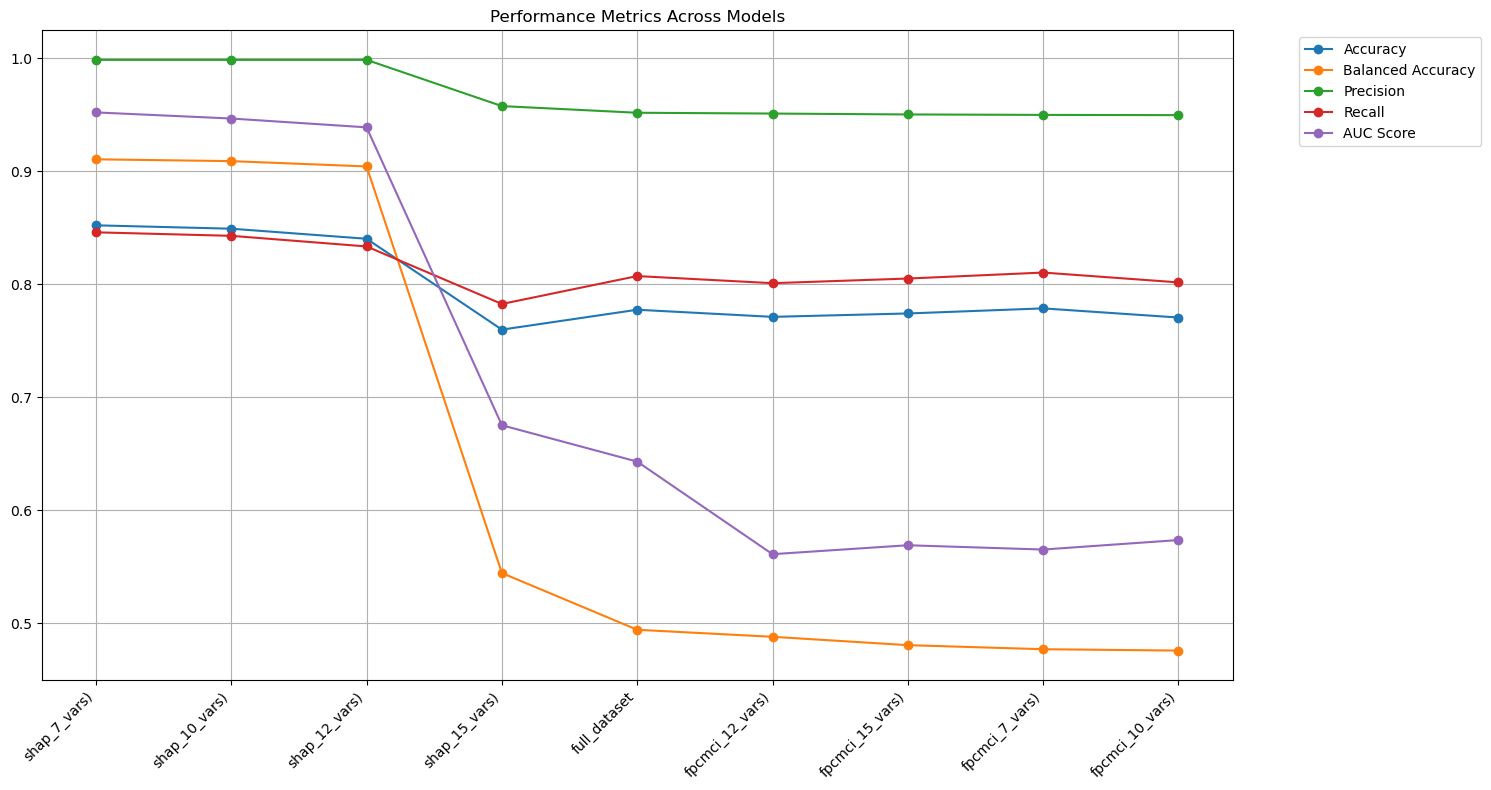

In [12]:
if __name__ == "__main__":
    data_path = 'Downloads/data_tep/'
    
    shap_vars = ["XMV(11)", "XMEAS(17)", "XMEAS(20)", "XMV(10)", 
                 "XMEAS(18)", "XMEAS(5)", "XMEAS(24)", "XMEAS(9)", 
                 "XMEAS(21)", "XMEAS(8)", "XMEAS(39)", "XMEAS(1)",
                 "XMEAS(37)", "XMEAS(6)", "XMEAS(14)"]
    
    fpcmci_vars = ["XMEAS(12)", "XMV(7)", "XMEAS(17)", "XMEAS(2)", 
                   "XMEAS(40)", "XMV(8)", "XMEAS(15)", "XMEAS(39)", 
                   "XMEAS(14)", "XMEAS(25)", "XMEAS(26)", "XMEAS(5)",
                   "XMV(1)", "XMEAS(41)", "XMEAS(28)"]
    
    n_vars_list = [7, 10, 12, 15]
    
    print("Loading and preparing datasets...")
    X_train, y_train, X_test, y_test = create_separate_datasets()
    feature_names = create_feature_names(X_train.shape[1])
    
    results = []
    
    metrics_full = train_knn_classifier(X_train, X_test, y_train, y_test, "full_dataset")
    results.append(metrics_full)
    
    for n_vars in n_vars_list:
        selected_vars = shap_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics = train_knn_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"shap_{n_vars}_vars)"
        )
        results.append(metrics)
    
    for n_vars in n_vars_list:
        selected_vars = fpcmci_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics = train_knn_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"fpcmci_{n_vars}_vars)"
        )
        results.append(metrics)
    
    comparison_df = pd.DataFrame(results)
    comparison_df = comparison_df.set_index('Model')
    comparison_df = comparison_df.round(4)
    
    comparison_df = comparison_df.sort_values('Balanced Accuracy', ascending=False)
    
    print("\nModel Comparison (sorted by Balanced Accuracy):")
    print(comparison_df)
    
    comparison_df.to_csv('model_comparison_results_detailed.csv')
    print("\nResults have been saved to 'model_comparison_results_detailed.csv'")
    
    plt.figure(figsize=(15, 8))
    metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC Score']
    
    for metric in metrics_to_plot:
        plt.plot(comparison_df.index, comparison_df[metric], marker='o', label=metric)
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Performance Metrics Across Models')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Loading and preparing datasets...

Training full_dataset (features: 52)...


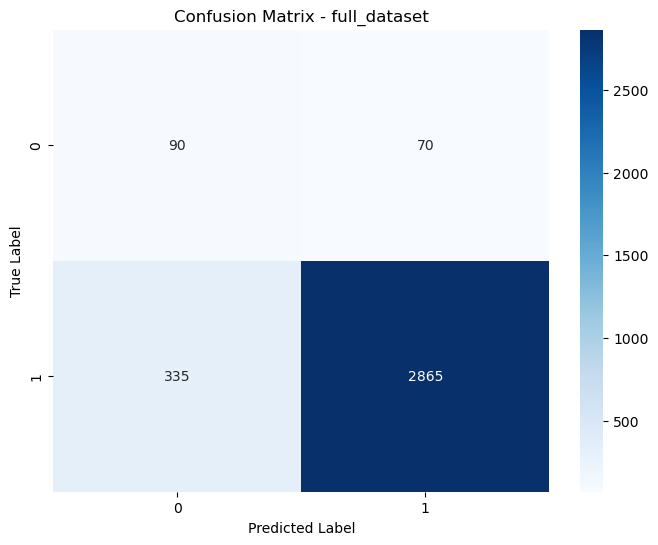


Training shap_7_vars) (features: 7)...


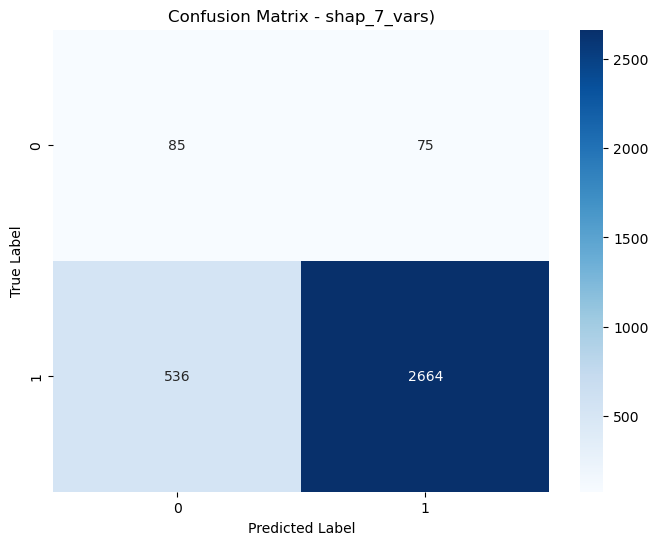

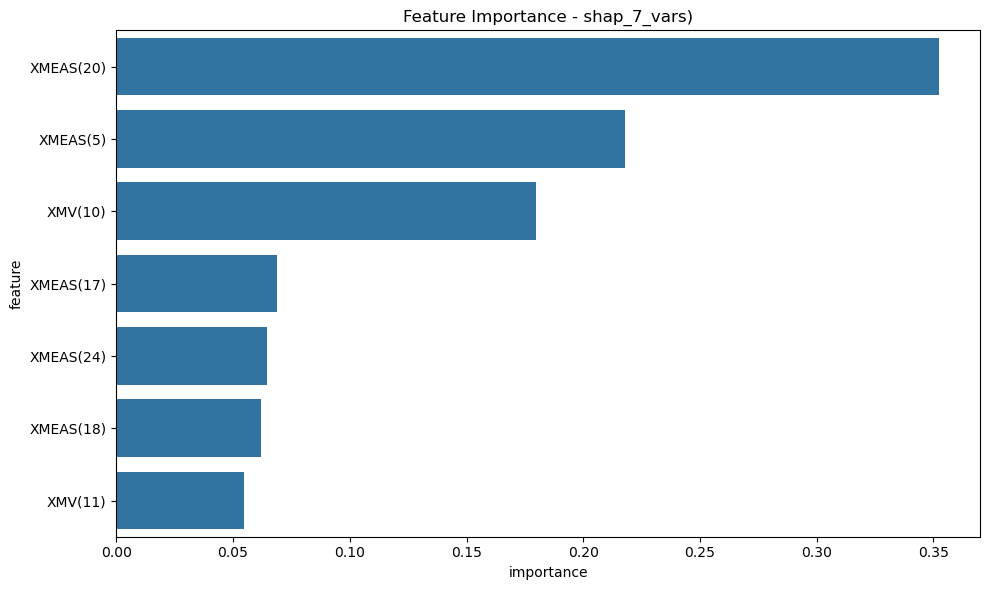


Training shap_10_vars) (features: 10)...


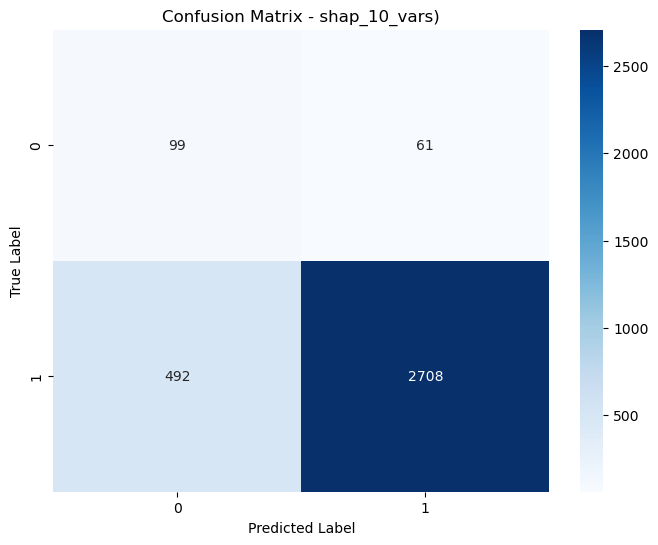

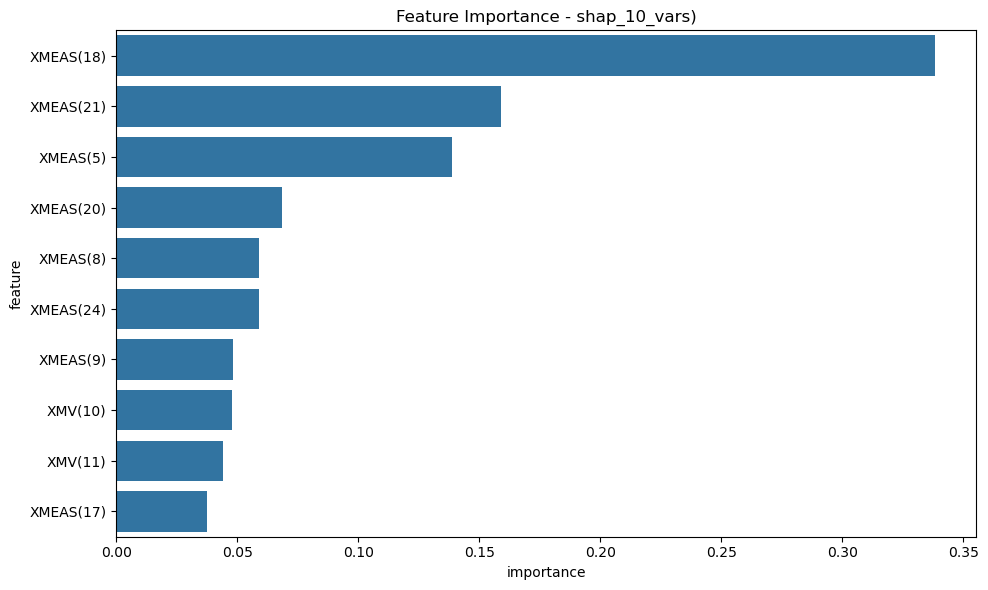


Training shap_12_vars) (features: 12)...


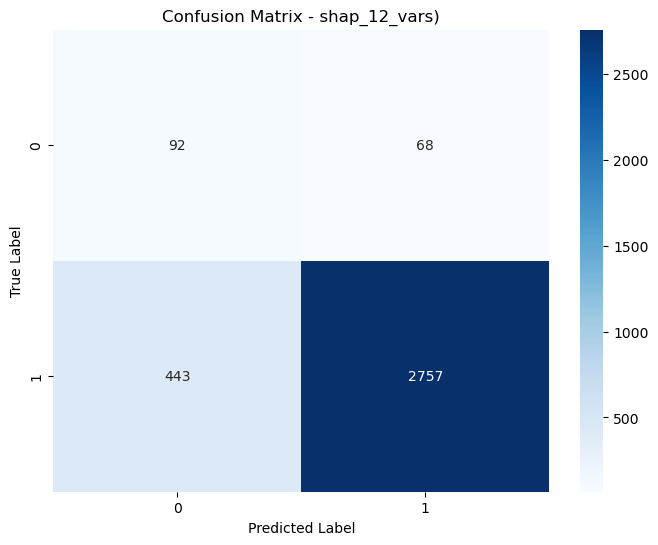

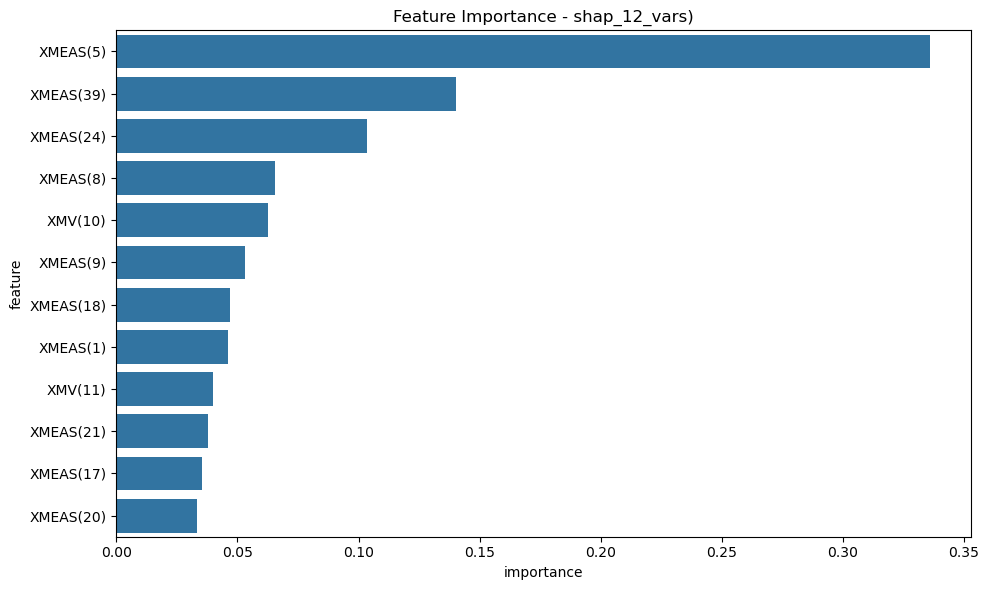


Training shap_15_vars) (features: 15)...


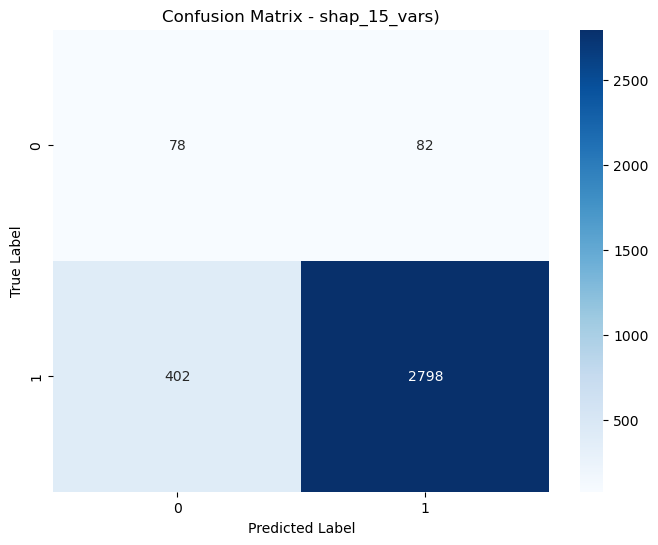

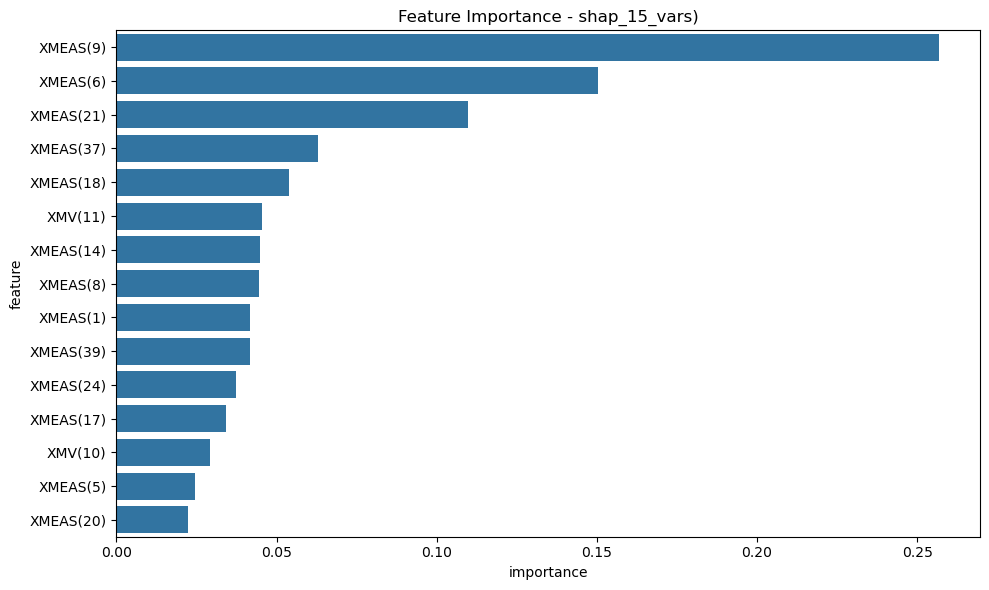


Training fpcmci_7_vars) (features: 7)...


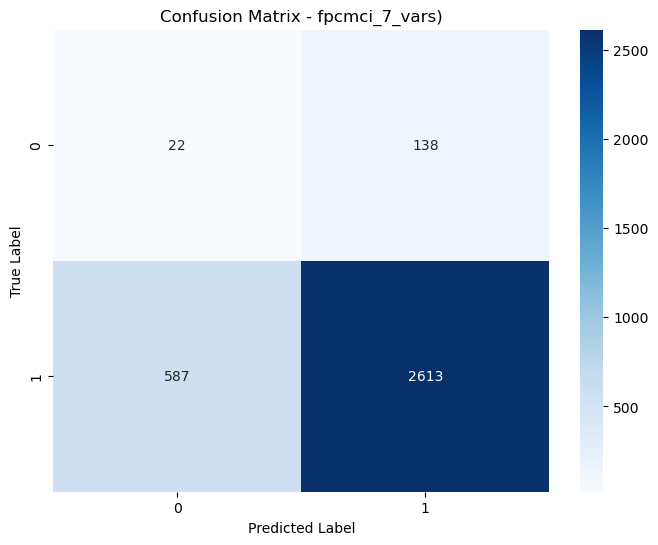

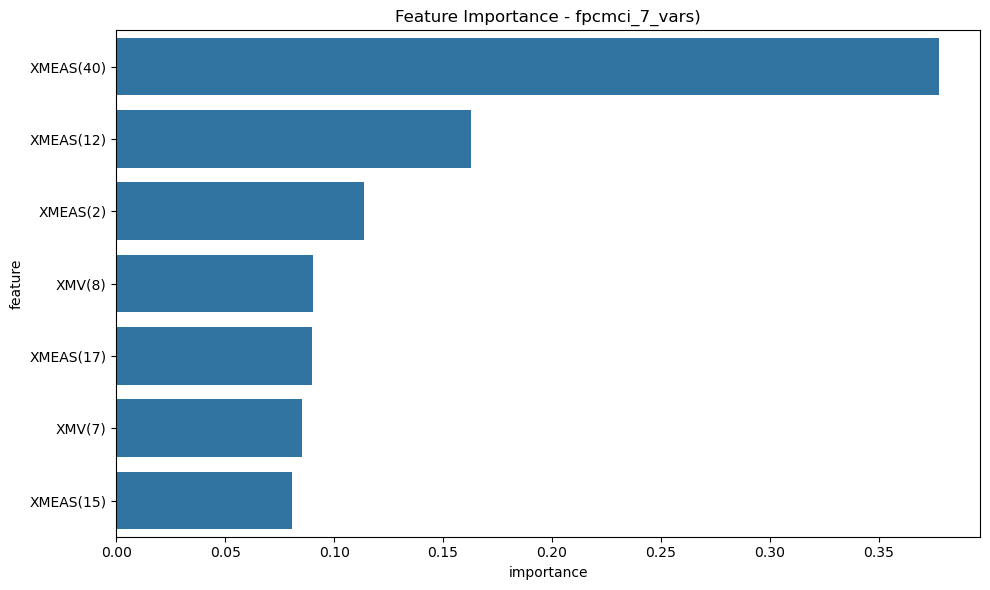


Training fpcmci_10_vars) (features: 10)...


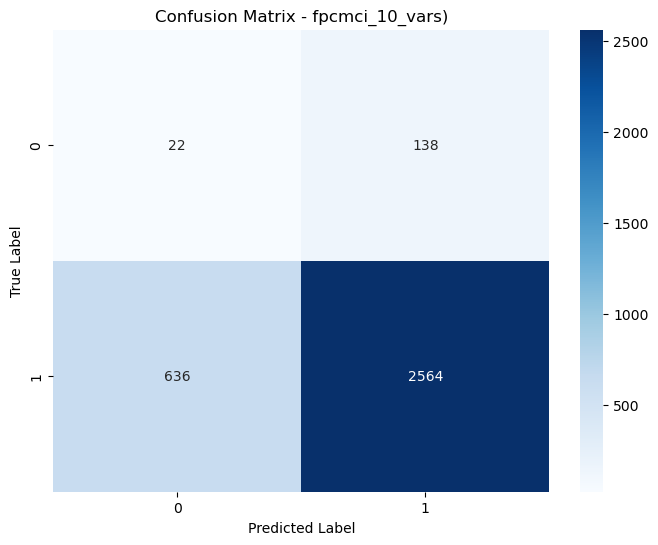

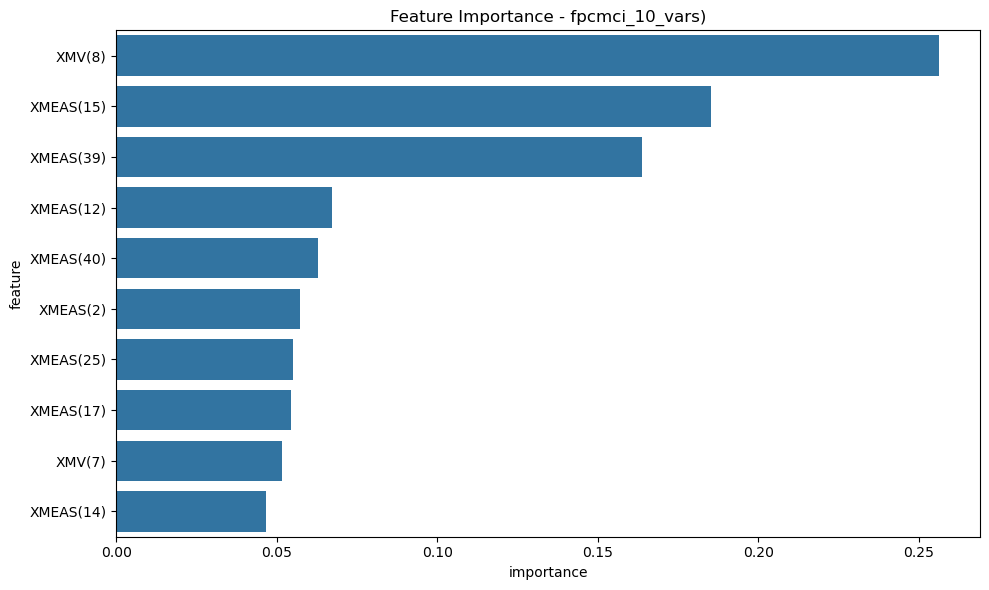


Training fpcmci_12_vars) (features: 12)...


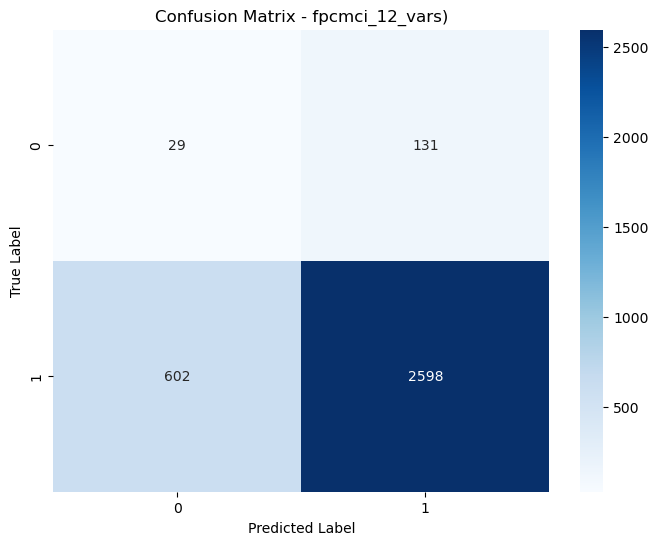

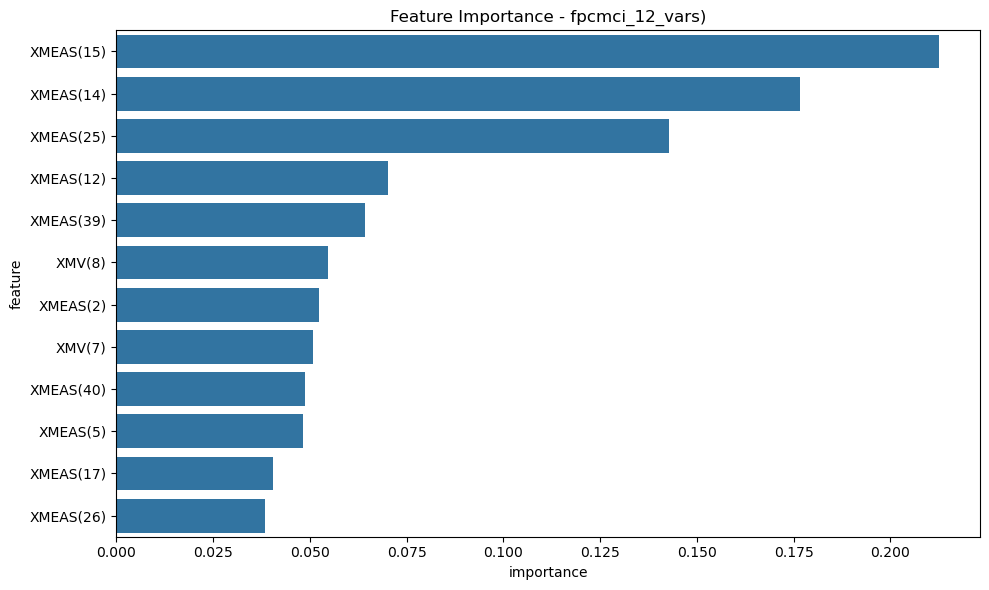


Training fpcmci_15_vars) (features: 15)...


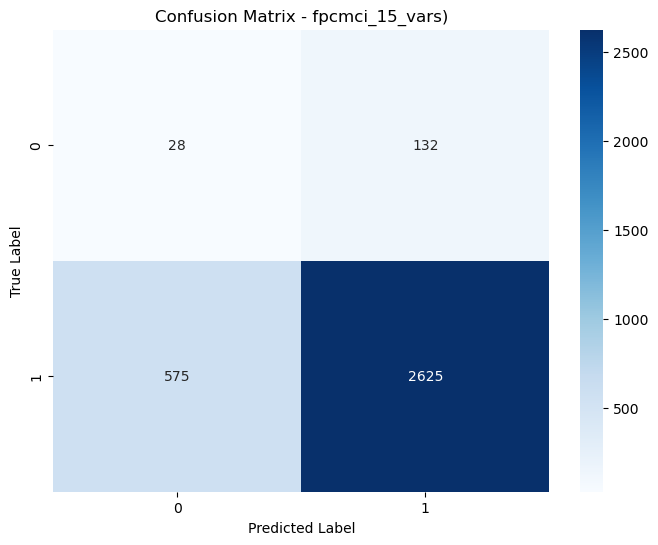

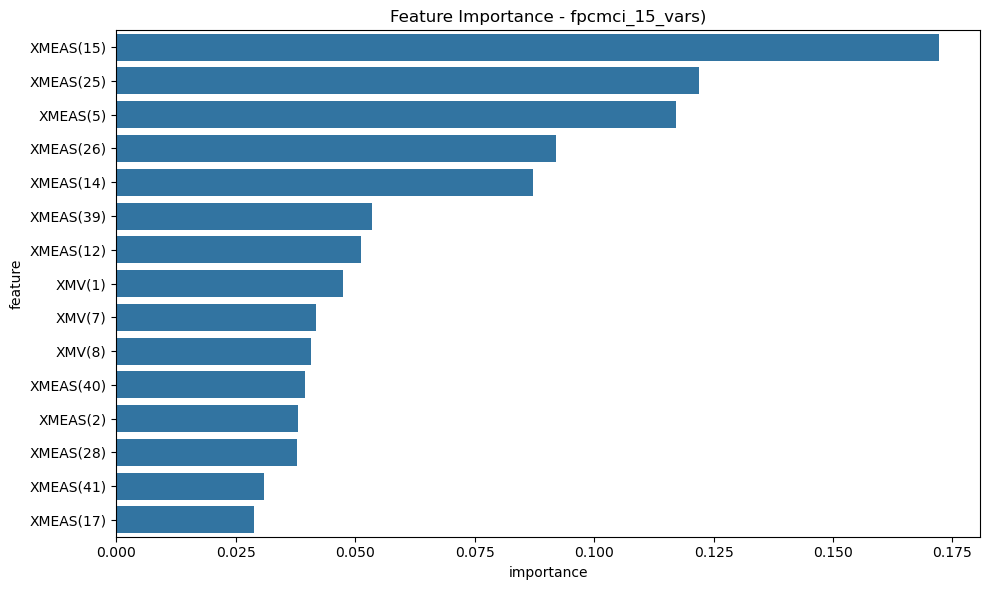


Model Comparison (sorted by Balanced Accuracy):
                 N_Features  Accuracy  Balanced Accuracy  Precision  Recall  \
Model                                                                         
shap_10_vars)            10    0.8354             0.7325     0.9780  0.8462   
full_dataset             52    0.8795             0.7289     0.9761  0.8953   
shap_12_vars)            12    0.8479             0.7183     0.9759  0.8616   
shap_7_vars)              7    0.8182             0.6819     0.9726  0.8325   
shap_15_vars)            15    0.8560             0.6809     0.9715  0.8744   
fpcmci_15_vars)          15    0.7896             0.4977     0.9521  0.8203   
fpcmci_12_vars)          12    0.7818             0.4966     0.9520  0.8119   
fpcmci_7_vars)            7    0.7842             0.4770     0.9498  0.8166   
fpcmci_10_vars)          10    0.7696             0.4694     0.9489  0.8012   

                 AUC Score  best_subsample  best_n_estimators  \
Model           

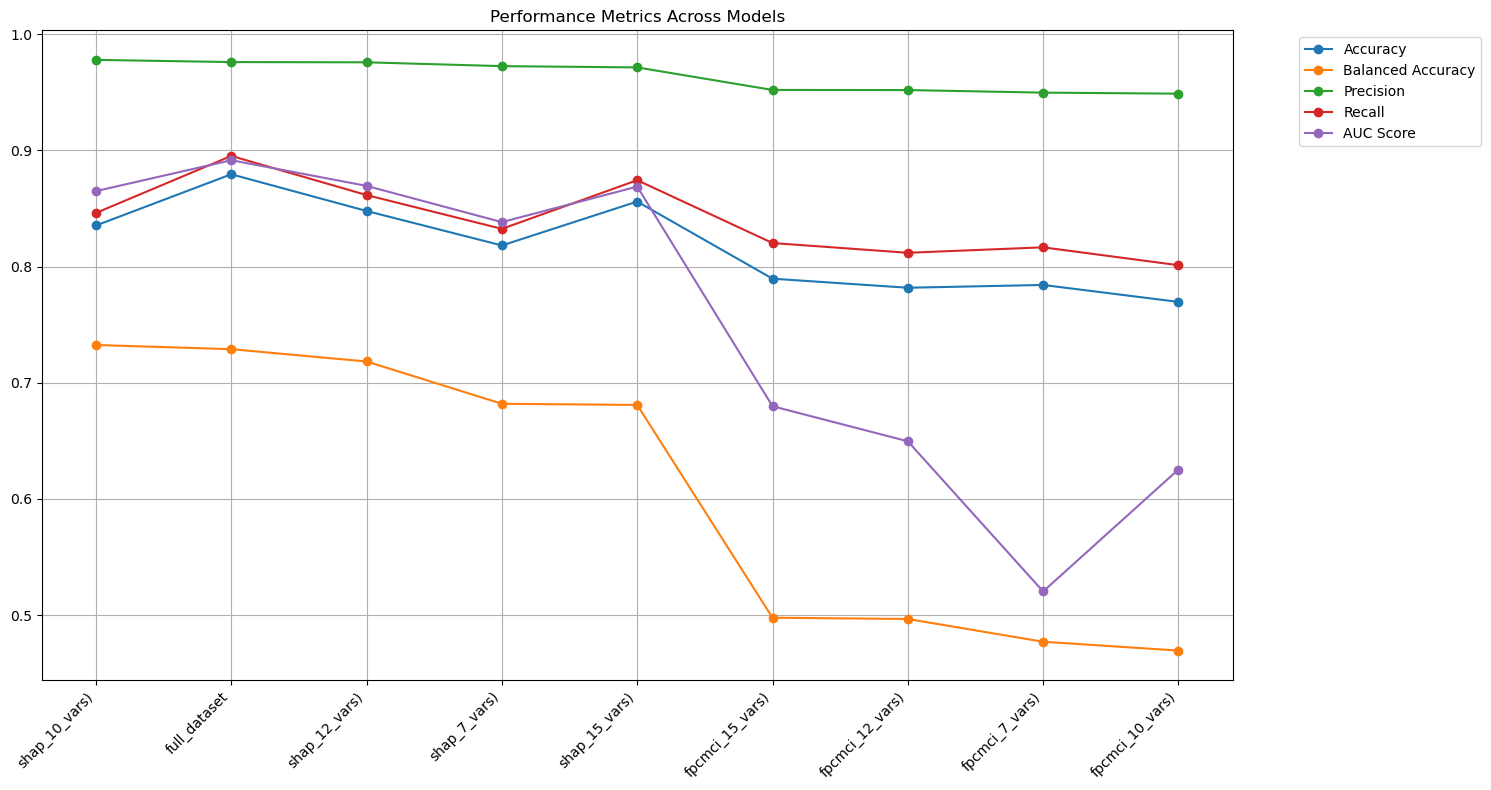

In [13]:
if __name__ == "__main__":
    data_path = 'Downloads/data_tep/'
    
    shap_vars = ["XMV(11)", "XMEAS(17)", "XMEAS(20)", "XMV(10)", 
                 "XMEAS(18)", "XMEAS(5)", "XMEAS(24)", "XMEAS(9)", 
                 "XMEAS(21)", "XMEAS(8)", "XMEAS(39)", "XMEAS(1)",
                 "XMEAS(37)", "XMEAS(6)", "XMEAS(14)"]
    
    fpcmci_vars = ["XMEAS(12)", "XMV(7)", "XMEAS(17)", "XMEAS(2)", 
                   "XMEAS(40)", "XMV(8)", "XMEAS(15)", "XMEAS(39)", 
                   "XMEAS(14)", "XMEAS(25)", "XMEAS(26)", "XMEAS(5)",
                   "XMV(1)", "XMEAS(41)", "XMEAS(28)"]
    
    n_vars_list = [7, 10, 12, 15]
    
    print("Loading and preparing datasets...")
    X_train, y_train, X_test, y_test = create_separate_datasets()
    feature_names = create_feature_names(X_train.shape[1])
    
    results = []
    
    metrics_full = train_xgboost_classifier(X_train, X_test, y_train, y_test, "full_dataset", feature_names)
    results.append(metrics_full)
    
    for n_vars in n_vars_list:
        selected_vars = shap_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics = train_xgboost_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"shap_{n_vars}_vars)",
            selected_vars  
        )
        results.append(metrics)
    
    for n_vars in n_vars_list:
        selected_vars = fpcmci_vars[:n_vars]
        X_train_selected = get_selected_features(X_train, feature_names, selected_vars)
        X_test_selected = get_selected_features(X_test, feature_names, selected_vars)
        
        metrics = train_xgboost_classifier(
            X_train_selected, X_test_selected, y_train, y_test, 
            f"fpcmci_{n_vars}_vars)",
            selected_vars  
        )
        results.append(metrics)
    
    comparison_df = pd.DataFrame(results)
    comparison_df = comparison_df.set_index('Model')
    comparison_df = comparison_df.round(4)
    
    comparison_df = comparison_df.sort_values('Balanced Accuracy', ascending=False)
    
    print("\nModel Comparison (sorted by Balanced Accuracy):")
    print(comparison_df)
    
    comparison_df.to_csv('model_comparison_results_detailed.csv')
    print("\nResults have been saved to 'model_comparison_results_detailed.csv'")
    
    plt.figure(figsize=(15, 8))
    metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC Score']
    
    for metric in metrics_to_plot:
        plt.plot(comparison_df.index, comparison_df[metric], marker='o', label=metric)
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Performance Metrics Across Models')
    plt.tight_layout()
    plt.grid(True)
    plt.show()